# Preparation

In [1]:
# import all libraries
import os
import glob
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import math
import xml.etree.ElementTree as ET

#make all folders
curfolder = os.getcwd()
flesh_folder = os.path.dirname(curfolder)
mtfolder = curfolder + '/Output_TimeSeries/'
processedfolder = curfolder + '/TS_processed/'
vidfolder = flesh_folder + '/Motion_Tracking_Folder/Output_Videos/'

# get all the files in the folder
mtfiles = glob.glob(mtfolder + '*body_world.csv')
vidfiles = glob.glob(vidfolder + '*.mp4')

['/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/Output_TimeSeries/kalt_g_ch2_g20_compr.mp4_body_world.csv', '/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/Output_TimeSeries/leise_g_ch2_g18_compr.mp4_body_world.csv', '/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/Output_TimeSeries/langsam_g_ch2_g8_compr.mp4_body_world.csv', '/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/Output_TimeSeries/kalt_g_ch2_g17_compr.mp4_body_world.csv', '/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/Output_TimeSeries/rennen_g_ch3_g17_compr.mp4_body_world.csv', '/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/Output_TimeSeries/rennen_g_ch3_g20_compr.mp4_body_world.csv', '/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/Ou

# Clean, flip, interpolate, smooth the data

In [2]:
# returns a cleaned file with visibility columns dropped and with fileID and participantID added
def clean_data(file):
    # reads file
    sample = pd.read_csv(file)
    sample
    fileID = os.path.basename(file)
# replace _body.csv with ''
    fileID = fileID.replace('_body_world.csv', '')

# add fileID column to the sample
    sample['fileID'] = fileID

# get the participant ID from the fileID:
    split_string = fileID.split('ch')[1]
    split_string = split_string.split('_g')
    chain_num = split_string[0]
    split_string_gen = split_string[1].split("_compr")
    gen_num = split_string_gen[0]
    participantID = "ch" + chain_num + "g" +gen_num
    sample['participantID'] = participantID

# in the sample, get rid of all columns that contain visibility
    visibility_columns = [col for col in sample.columns if 'visibility' in col]
    sample = sample.drop(visibility_columns, axis=1)
    return sample

# returns data with y values flipped. 
# code modified from Trujillo, J.P. & Pouw, W.T.J.L. (2021-11-18). Kinematic Feature Extraction for Motion Tracking Analysis. Retrieved from: https://github.com/WimPouw/EnvisionBootcamp2021/tree/main/Python/Analysis_kinematic_features
def flip_data(df):
    cols = df.columns
    cols  = [col for col in df.columns if 'Y_' in col]
    cols = list(cols)
        # first get the vertical height of the configuration
        # we only do this for the first frame; the transformation will be applied to all frames
    maxpoint = []
    for joint in cols:
        maxpoint.append(df.loc[0, joint])
        # iterate over each joint, in each frame, to flip the y-axis
    for frame in range(len(df)):
        for joint in cols:
            ytrans = max(maxpoint) - df.loc[frame, joint] - 1
            df.loc[frame, joint] = ytrans
    return df

# returns the file with all missing data interpolated 
def interpolate(sample):
    cols = sample.columns

# put away time and fileID from cols
    cols = cols.drop(['time', 'fileID', 'participantID'])

# loop over the cols and interpolate missing data
    for col in cols:
        sample[col] = sample[col].interpolate(method='linear', x = sample['time'], limit=10)
    return cols, sample

# returns the file with the data smoothed
def smooth_data(sample):
    cols_upperbody = ['X_NOSE', 'Y_NOSE', 'Z_NOSE', 'X_LEFT_EYE_INNER', 'Y_LEFT_EYE_INNER', 'Z_LEFT_EYE_INNER', 'X_LEFT_EYE', 'Y_LEFT_EYE', 'Z_LEFT_EYE', 'X_LEFT_EYE_OUTER', 'Y_LEFT_EYE_OUTER', 'Z_LEFT_EYE_OUTER', 'X_RIGHT_EYE_OUTER', 'Y_RIGHT_EYE_OUTER', 'Z_RIGHT_EYE_OUTER', 'X_RIGHT_EYE', 'Y_RIGHT_EYE', 'Z_RIGHT_EYE', 'X_RIGHT_EYE_OUTER.1', 'Y_RIGHT_EYE_OUTER.1', 'Z_RIGHT_EYE_OUTER.1', 'X_LEFT_EAR', 'Y_LEFT_EAR', 'Z_LEFT_EAR', 'X_RIGHT_EAR', 'Y_RIGHT_EAR', 'Z_RIGHT_EAR', 'X_MOUTH_LEFT', 'Y_MOUTH_LEFT', 'Z_MOUTH_LEFT', 'X_MOUTH_RIGHT', 'Y_MOUTH_RIGHT', 'Z_MOUTH_RIGHT', 'X_LEFT_SHOULDER', 'Y_LEFT_SHOULDER', 'Z_LEFT_SHOULDER', 'X_RIGHT_SHOULDER', 'Y_RIGHT_SHOULDER', 'Z_RIGHT_SHOULDER', 'X_LEFT_ELBOW', 'Y_LEFT_ELBOW', 'Z_LEFT_ELBOW', 'X_RIGHT_ELBOW', 'Y_RIGHT_ELBOW', 'Z_RIGHT_ELBOW', 'X_LEFT_WRIST', 'Y_LEFT_WRIST', 'Z_LEFT_WRIST', 'X_RIGHT_WRIST', 'Y_RIGHT_WRIST', 'Z_RIGHT_WRIST', 'X_LEFT_PINKY', 'Y_LEFT_PINKY', 'Z_LEFT_PINKY', 'X_RIGHT_PINKY', 'Y_RIGHT_PINKY', 'Z_RIGHT_PINKY', 'X_LEFT_INDEX', 'Y_LEFT_INDEX', 'Z_LEFT_INDEX', 'X_RIGHT_INDEX', 'Y_RIGHT_INDEX', 'Z_RIGHT_INDEX', 'X_LEFT_THUMB', 'Y_LEFT_THUMB', 'Z_LEFT_THUMB', 'X_RIGHT_THUMB', 'Y_RIGHT_THUMB']
    cols_lowerbody = ['X_LEFT_HIP',
       'Y_LEFT_HIP', 'Z_LEFT_HIP', 'X_RIGHT_HIP', 'Y_RIGHT_HIP', 'Z_RIGHT_HIP',
       'X_LEFT_KNEE', 'Y_LEFT_KNEE', 'Z_LEFT_KNEE', 'X_RIGHT_KNEE',
       'Y_RIGHT_KNEE', 'Z_RIGHT_KNEE', 'X_LEFT_ANKLE', 'Y_LEFT_ANKLE',
       'Z_LEFT_ANKLE', 'X_RIGHT_ANKLE', 'Y_RIGHT_ANKLE', 'Z_RIGHT_ANKLE',
       'X_LEFT_HEEL', 'Y_LEFT_HEEL', 'Z_LEFT_HEEL', 'X_RIGHT_HEEL',
       'Y_RIGHT_HEEL', 'Z_RIGHT_HEEL', 'X_LEFT_FOOT_INDEX',
       'Y_LEFT_FOOT_INDEX', 'Z_LEFT_FOOT_INDEX', 'X_RIGHT_FOOT_INDEX',
       'Y_RIGHT_FOOT_INDEX', 'Z_RIGHT_FOOT_INDEX']

# smooth upperbody and face with savgol 20,4
    for col in cols_upperbody:
        sample[col] = scipy.signal.savgol_filter(sample[col], 30, 1) 

# smooth lowerbod with savgol 30,3
    for col in cols_lowerbody:  
        sample[col] = scipy.signal.savgol_filter(sample[col], 30, 1) 
    return(sample)



# Obtain heights and normalize data


In [3]:
# returns the height of the body of the individual in the file  adds in a new mid shoulder point and mid ankle point to the file
def obtain_height_by_ankle2D(sample):
    #obtain left shoulder values
    x_left = sample['X_LEFT_SHOULDER'].iloc[0]
    y_left = sample['Y_LEFT_SHOULDER'].iloc[0]
    left_shoulder = (x_left, y_left)
    left_shoulder = np.array(left_shoulder)

   #obtain right shoulder values
    x_right = sample['X_RIGHT_SHOULDER'].iloc[0]
    y_right = sample['Y_RIGHT_SHOULDER'].iloc[0]
    right_shoulder = (x_right, y_right)
    right_shoulder = np.array(right_shoulder)

    #calculate the mid shoulder point
    new_shoulder_point = (left_shoulder + right_shoulder)/2 

    # obtain left ankle values
    x_left = sample['X_LEFT_ANKLE'].iloc[0]
    y_left = sample['Y_LEFT_ANKLE'].iloc[0]
    left_ankle = (x_left, y_left)
    left_ankle = np.array(left_ankle)

    # obtain right ankle values
    x_right = sample['X_RIGHT_ANKLE'].iloc[0]
    y_right = sample['Y_RIGHT_ANKLE'].iloc[0]
    right_ankle = (x_right, y_right)
    right_ankle = np.array(right_ankle)

    # calculate the mid ankle point 
    new_ankle_point = (left_ankle + right_ankle)/2

    sample['X_MID_ANKLE'] = new_ankle_point[0] ##FLAG: why is the same chunk of code below again?
    sample['Y_MID_ANKLE'] = new_ankle_point[1]

    # length of body for 2 dimensions (identical result as above)
    length_of_body = math.sqrt(((new_shoulder_point[0]-new_ankle_point[0])**2)+((new_shoulder_point[1]-new_ankle_point[1])**2))

    # adds the points to the sample sheet
    sample['X_MID_SHOULDER'] = new_shoulder_point[0]
    sample['Y_MID_SHOULDER'] = new_shoulder_point[1]

    return length_of_body

# returns the file with all values normalized by the height of the body
def normalize_by_body2D(sample, length_of_body):
    cols = sample.columns
    # put away time and fileID and participantID from cols
    cols = cols.drop(['time', 'fileID', 'participantID'])
    cols = [col for col in cols if 'Z_' not in col]
    # divide by the length of the body
    for col in cols: 
        sample[col] = sample[col] / length_of_body
    return(sample)



# 2D Animation

In [4]:
## plot all the keypoints in 2d space
## Code modified from Šárka Kadavá
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import ffmpeg

import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import ffmpeg

def animation2D(sample):
    # Define the tracking data
    MT_tracking = sample

    # Create a figure and axis for 2D plotting (keeping the original size)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)

    # Define the number of frames (assuming sample is a DataFrame with multiple rows)
    num_frames = len(MT_tracking)

    # Define the scatter plot (this will be updated in each frame)
    scatter = ax.scatter([], [], marker='o')

    # Update function for animation
    def update(frame):
        # Clear the axis for each frame (reset)
        ax.clear()

        # Set axis labels and title
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_title('2D Animation')

        # Set the limits of the axes, keeping the original similar limits
        ax.set_xlim(-1.1, 1.1)  # Keeping similar range to original X limits
        ax.set_ylim(-0.8, 0.8)   # Keeping similar range to original Y limits

        # Get the data for the current frame
        frame_data = MT_tracking.iloc[frame]
        x = frame_data.filter(like='X_')
        y = frame_data.filter(like='Y_')

        # Create the scatter plot for the current frame
        scatter = ax.scatter(x, y, color='red')

        return scatter,

    # Create the animation
    ani = FuncAnimation(fig, update, frames=num_frames, interval=1000/60)

    # Save the animation as a video
    ani.save('2d_animation.mp4', writer='ffmpeg')


# Derive Speed and Smooth

In [5]:
# returns a file with derived smoothed speed (and changes from cm/frame/second to cm/second)
def derive_2dspeed_smooth(cols, sample, sr):
    speedcols = [col.replace('Y_', '') for col in cols] 
    speedcols = [col.replace('X_', '') for col in speedcols]
    speedcols = [col.replace('Z_', '') for col in speedcols]

# keep only unique values
    speedcols = list(set(speedcols))

    for col in speedcols:
        x = sample['X_' + col]
        y = sample['Y_' + col]

    # calculate speed
        sample[col + '_speed2D'] = np.insert(np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2), 0, 0)
        #switch to centimeters/second
        sample[col + '_speed2D'] = sample[col + '_speed2D']*sr
    #  smooth speed:
    for col in speedcols:
        sample[col + '_speed2D'] = scipy.signal.savgol_filter(sample[col + '_speed2D'], 20, 4)
    return(speedcols, sample)

# Derive vertical velocity and smooth

In [6]:
# returns the file with columns for vertical velocity for each key point
def derive_vertical_vel_smooth(sample):
    #Get a list of the columns that contain Y_
    verticalcols = [col for col in sample.columns if 'Y_' in col]
    verticalcols = [col for col in verticalcols if 'speed' not in col]

# calculate the velocity
    for col in verticalcols:
        sample[col + '_velocity'] = np.insert(np.diff(sample[col]), 0, 0)  
    vel_cols = [col for col in sample.columns if "_velocity" in col]
    for col in vel_cols:
        sample[col] = scipy.signal.savgol_filter(sample[col], 20, 4)
    return verticalcols, sample


# Derive Acceleration and Smooth

In [7]:
# returns the file with columns for acceleration for each key point
def derive_accel2D_smooth(speedcols, sample):
    # calculate acceleration as derivate of speed
    for col in speedcols:
        sample[col + '_acceleration2D'] = np.insert(np.diff(sample[col + "_speed2D"]), 0, 0) 
    accel_cols = [col for col in sample.columns if "_acceleration2D" in col]
    # smooth the acceleration columns
    for col in accel_cols:
        sample[col] = scipy.signal.savgol_filter(sample[col], 20, 4)
    return (sample)

# Derive Jerk and Smooth

In [8]:
# returns the file with columns for jerk derived from acceleration for each key point
def derive_jerk2D_smooth(speedcols, sample):
    # calcuates the jerk for each vertical column
    for col in speedcols:
        sample[col + '_jerk2D'] = np.insert(np.diff(sample[col + "_acceleration2D"]), 0, 0)
    # gets a list of all jerk columns
    jerk_cols = [col for col in sample.columns if "_jerk2D" in col]
    # smooths all jerk columns
    for col in jerk_cols:
        sample[col] = scipy.signal.savgol_filter(sample[col], 20, 4)
    return (sample)


# Final code to process every file in Output_TimeSeries

Clean every file

In [9]:
# This block contains code to go through every file and clean it

import os
import glob
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#get the timeseries files
curfolder = os.getcwd()
print(curfolder)

flesh_folder = os.path.dirname(curfolder)
print(flesh_folder)

mtfolder = curfolder + '/Output_TimeSeries/'
print(mtfolder)

cleanedfolder = curfolder + '/TS_cleaned'
if not os.path.exists(cleanedfolder):
    os.makedirs(cleanedfolder) 
processedfolder = curfolder + '/TS_processed/'
if not os.path.exists(processedfolder):
    os.makedirs(processedfolder)
vidfolder = flesh_folder + '/Motion_Tracking_Folder/Output_Videos/'

# get all the files in the folder
mtfiles = glob.glob(mtfolder + '*body_world.csv')

vidfiles = glob.glob(vidfolder + '*.mp4')

# Loop through every file in the timeseries folder, clean it, and save it to a cleaned folder
for file in mtfiles:
    # clean, flip, interpolate, and smooth
    sample = clean_data(file)
    sample = flip_data(sample)
    cols, sample = interpolate(sample)
    sample = smooth_data(sample)
    # save it 
    fileID=sample['fileID'][0]
    globals()[fileID] = sample
    globals()[fileID].to_csv(os.path.join(cleanedfolder, f'{fileID}.csv'), index=False)




/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/Output_TimeSeries/
['/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/Output_TimeSeries/kalt_g_ch2_g20_compr.mp4_body_world.csv', '/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/Output_TimeSeries/leise_g_ch2_g18_compr.mp4_body_world.csv', '/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/Output_TimeSeries/langsam_g_ch2_g8_compr.mp4_body_world.csv', '/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/Output_TimeSeries/kalt_g_ch2_g17_compr.mp4_body_world.csv', '/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/Output_TimeSeries/rennen_g_ch3_g17_compr.mp4_

Create a dictionary of heights

In [10]:
cleanedfolder = curfolder + '/TS_cleaned'

dict_of_heights = {} #create empty dictionary of heights
cleanedfiles = glob.glob(cleanedfolder + '/*.csv')

# loop to obtain the height from every file and save it in a dictionary
for file in cleanedfiles:
    sample = pd.read_csv(file)
    participantID = (sample['participantID'].iloc[0])
    # get the height from the function
    height = obtain_height_by_ankle2D(sample)
    if math.isnan(height):
        continue
    # add the height to the participant's place in the dictionary
    if participantID not in dict_of_heights:
        dict_of_heights[participantID] = [height]
    else:
        dict_of_heights[participantID].append(height)

Create a dictionary of average heights

In [ ]:
# create empty dictionaries for the average heights
dict_of_means = {}
dict_of_sd = {}

# get the mean height for each participants and use this as the height
for key in dict_of_heights: 
    values = np.array(dict_of_heights[key])
    mean = np.mean(values)
    sd = np.std(values)
    dict_of_means[key] = mean
    dict_of_sd[key]= sd



Normalize all data by mean heights and derive features

In [15]:
# loop to normalize all data based on mean height and derive features. Saves to TS_processed folder. 
for file in cleanedfiles:
    print(file)
    sample = pd.read_csv(file)

    # normalize all data based on means
    participantID = (sample['participantID'].iloc[0])
    mean_body_length = dict_of_means[participantID]
    sample = normalize_by_body2D(sample, mean_body_length)

    # derive the kinematic feature of speed
    sr = 1/np.mean(np.diff(sample['time']))
    speedcols, sample = derive_2dspeed_smooth(cols, sample, sr)

    ## combine the arm timeseries into one for later feature extraction
    sample['ARMTOTAL_speed2D'] = np.sqrt(sample['LEFT_WRIST_speed2D']**2 + sample['RIGHT_WRIST_speed2D']**2 + sample['LEFT_ELBOW_speed2D']**2 + sample['RIGHT_ELBOW_speed2D']**2)
    sample['LEGTAL_speed2D'] = np.sqrt(sample['LEFT_ANKLE_speed2D']**2 + sample['RIGHT_ANKLE_speed2D']**2)

    # derive the kinematic features of vertical velocity, acceleration, jerk
    verticalcols, sample = derive_vertical_vel_smooth(sample)
    sample = derive_accel2D_smooth(speedcols, sample)
    sample = derive_jerk2D_smooth(speedcols, sample)
    fileID = sample['fileID'][0]
    globals()[fileID] = sample
    globals()[fileID].to_csv(os.path.join(processedfolder, f'{fileID}.csv'), index=False)
    

/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_cleaned/langsam_g_ch3_g7_compr.mp4.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_cleaned/Donner_g_ch2_g12_compr.mp4.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_cleaned/kalt_g_ch3_g19_compr.mp4.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_cleaned/langsam_g_ch3_g12_compr.mp4.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_cleaned/leise_g_ch1_g0_compr.mp4.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_cleaned/langsam_g_ch1_g8_compr.mp4.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_cleaned/kalt_g_ch1_g14_compr.mp4.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder

# Functions to align data with ELAN Annotations

All code was modified from code written by Šárka Kadavá

 Define functions to parse the ELAN files

In [16]:
import xml.etree.ElementTree as ET

# Function to parse elan file
def parse_eaf_file(eaf_file, rel_tiers):
    tree = ET.parse(eaf_file)
    root = tree.getroot()

    annotations = []
    relevant_tiers = {rel_tiers}
    
    time_order = root.find('TIME_ORDER')
    if time_order == None: 
        print ("no time order")
        print()
        annotations.append({
                        'tier_id': 'na',
                        'annotation_id': 'na',
                        'start_time': 'na',
                        'end_time': 'na',
                        'annotation_value': None
                    })
    else:
        time_slots = {time_slot.attrib['TIME_SLOT_ID']: time_slot.attrib['TIME_VALUE'] for time_slot in time_order}


        for tier in root.findall('TIER'):
            tier_id = tier.attrib['TIER_ID']
            if tier_id in relevant_tiers:
                for annotation in tier.findall('ANNOTATION/ALIGNABLE_ANNOTATION'):
                    # Ensure required attributes are present
                    if 'TIME_SLOT_REF1' in annotation.attrib and 'TIME_SLOT_REF2' in annotation.attrib:
                        ts_ref1 = annotation.attrib['TIME_SLOT_REF1']
                        ts_ref2 = annotation.attrib['TIME_SLOT_REF2']
                        # Get annotation ID if it exists, otherwise set to None
                        ann_id = annotation.attrib.get('ANNOTATION_ID', None)
                        annotation_value = annotation.find('ANNOTATION_VALUE').text.strip()
                        annotations.append({
                            'tier_id': tier_id,
                            'annotation_id': ann_id,
                            'start_time': time_slots[ts_ref1],
                            'end_time': time_slots[ts_ref2],
                            'annotation_value': annotation_value
                        })

    return annotations

# Function to load annotations into csv
def fillAnno(TSfile, ANNOfile, colname):
    TSfile[colname] = None
    for row in ANNOfile.iterrows():
        start = float(row[1][0])
        end = float(row[1][1])
        value = str(row[1][2])
        TSfile.loc[(TSfile['time'] >= start) & (TSfile['time'] <= end), colname] = value

Code to align data with ELAN

In [18]:
# CREATE TXT FILE FOR EACH TIER FROM ELAN

################
#### arms ######
################


annofolder_manu = curfolder + '/ELAN_anno/'
print(annofolder_manu)
annofiles_manu= glob.glob(annofolder_manu + '*.eaf')

annotations_groundTruth = curfolder + '/annotations_groundTruth/'
os.makedirs(annotations_groundTruth)
arms_anno = curfolder + '/annotations_groundTruth/arms_annotations.txt'

 # skip files that we aren't including: 
toskip = [annofolder_manu + 'rennen_g_ch1_g17_compr.eaf', annofolder_manu + 'langsam_g_ch2_g8_compr.eaf']

with open(arms_anno, 'w') as f:
    for file in annofiles_manu:
        print('working on ' + file)
        # get the filename as the last element
        filename = file.split('\\')[-1]
        # replace _ELAN_tiers.eaf with ''
        filename = filename.replace('_ELAN_tiers.eaf', '')
        print('filename:')
        print(filename)
        print(toskip[0])
        if filename in toskip:
            print("this is faulty file")
            continue
        # parse the file
        annotations = parse_eaf_file(file, 'arms')
        # write the annotations
        for annotation in annotations:
            f.write(f"{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")

###################
#### upper body####
###################

upperbody_anno = curfolder + '/annotations_groundTruth/upperbody_annotations.txt'

with open(upperbody_anno, 'w') as f:
    for file in annofiles_manu:
        print('working on ' + file)
        # get the filename as the last element
        filename = file.split('\\')[-1]
        # replace _ELAN_tiers.eaf with ''
        filename = filename.replace('_ELAN_tiers.eaf', '')
        # parse the file
        if filename in toskip:
            print("this is faulty file")
            continue
        annotations = parse_eaf_file(file, 'upper_body')
        # write the annotations
        for annotation in annotations:
            f.write(f"{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")

###################
#### lower body####
###################

lowerbody_anno = curfolder + '/annotations_groundTruth/lowerbody_annotations.txt'

with open(lowerbody_anno, 'w') as f:
    for file in annofiles_manu:
        print('working on ' + file)
        # get the filename as the last element
        filename = file.split('\\')[-1]
        # replace _ELAN_tiers.eaf with ''
        filename = filename.replace('_ELAN_tiers.eaf', '')
        if filename in toskip:
            print("this is faulty file")
            continue
        # parse the file
        annotations = parse_eaf_file(file, 'lower_body')
        # write the annotations
        for annotation in annotations:
            f.write(f"{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")

###################
##### head ########
###################

head_anno = curfolder + '/annotations_groundTruth/head_annotations.txt'

with open(head_anno, 'w') as f:
    for file in annofiles_manu:
        print('working on ' + file)
        # get the filename as the last element
        filename = file.split('\\')[-1]
        # replace _ELAN_tiers.eaf with ''
        filename = filename.replace('_ELAN_tiers.eaf', '')
        print(filename)
        print(toskip[0])
        if filename in toskip:
            print("this is faulty file")
            continue
        # parse the file
        annotations = parse_eaf_file(file, 'head_mov')
        # write the annotations
        for annotation in annotations:
            f.write(f"{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")


/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/ELAN_anno/
working on /Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/ELAN_anno/Donner_g_ch3_g15_compr.eaf
filename:
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/ELAN_anno/Donner_g_ch3_g15_compr.eaf
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/ELAN_anno/rennen_g_ch1_g17_compr.eaf
working on /Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/ELAN_anno/langsam_g_ch1_g20_compr.eaf
filename:
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/ELAN_anno/langsam_g_ch1_g20_compr.eaf
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/ELAN_anno/rennen_g_ch1_g17_compr.eaf
working on /Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/

Merge the annotations with the data

In [19]:
# # ADD THE MOVEMENT ANNOTATION FROM TXTFILE TO THE DATAFRAME/CSV FILE THAT WE CREATED BY THE PROCESSING SCRIPT

# These are the annotations per tier that we just created from manual annotations
arms_anno = curfolder + '/annotations_groundTruth/arms_annotations.txt'
upperbody_anno = curfolder + '/annotations_groundTruth/upperbody_annotations.txt'
lowerbody_anno = curfolder + '/annotations_groundTruth/lowerbody_annotations.txt'
head_anno = curfolder + '/annotations_groundTruth/head_annotations.txt'

curfolder = os.getcwd()
processedfolder = curfolder + '/TS_processed/'
processedfiles = glob.glob(processedfolder + '*.csv')

movementfolder = curfolder + '/TS_movement/'
os.makedirs(movementfolder)

#videos that we need to leave out due to error so I will skip them
toskip = [processedfolder + 'rennen_g_ch1_g17_compr', processedfolder + 'langsam_g_ch2_g8_compr', processedfolder + 'langsam_g_ch2_g19_compr']

for file in processedfiles:
    print('working on ' + file)

    # TrialID
    trialid = file.split('\\')[-1].split('.')[0]

    if trialid in toskip:
        print("this is faulty file")
        continue

    trialid = trialid.replace('TS_processed', 'ELAN_anno')
    #trialid = trialid.replace('merged_', '')
    trialid = trialid + '.eaf'

    # Load the merged file
    merged = pd.read_csv(file)
    
    # Load the annotations as df
    arms = pd.read_csv(arms_anno, sep='\t', header=None)
    ub = pd.read_csv(upperbody_anno, sep='\t', header=None)
    lb = pd.read_csv(lowerbody_anno, sep='\t', header=None)
    head = pd.read_csv(head_anno, sep='\t', header=None)

    
    annos = [arms, ub, lb, head]

    # Loop over each tier and fill values into timeseries
    for anno_df in annos:
        # Get the annotations for the trialid
        anno_trial = anno_df[anno_df[3] == trialid] 
        
        if anno_trial.empty:
            print("empty")
            print('no annotations for ' + trialid)
            #add a column
            continue
        
        else:
            if anno_df.equals(arms):
                fillAnno(merged, anno_trial, 'arms')
            elif anno_df.equals(ub):
                fillAnno(merged, anno_trial, 'upper_body')
            elif anno_df.equals(lb):
                fillAnno(merged, anno_trial, 'lower_body')
            elif anno_df.equals(head):
                fillAnno(merged, anno_trial, 'head_mov')
            else:
                print('something went wrong')

    df = merged.copy()
    # check if each column exists in the dataframe
    col1 = 'arms'
    col2 = 'upper_body'
    col3 = 'lower_body'
    col4 = 'head_mov'
    # create a column if it doesn't exist. If it does, switch the labels. 
    if col1 not in df:
        df[col1] = 'no movement'
    else:
        df['arms'] = df['arms'].fillna('no movement')

    if col2 not in df:
        df[col2] = 'no movement'
    else:
        df['upper_body'] = df['upper_body'].fillna('no movement')

    if col3 not in df:
        df[col3] = 'no movement'
    else:
        df['lower_body'] = df['lower_body'].fillna('no movement')

    if col4 not in df:
        df[col4] = 'no movement'
    else:
        df['head_mov'] = df['head_mov'].fillna('no movement')

    # save the dataframe to TS movement
    fileID = trialid.replace('/ELAN_anno/', '/TS_movement/')
    print(fileID)
    globals()[fileID] = df
    globals()[fileID].to_csv(os.path.join(movementfolder, f'{fileID}.csv'), index=False)



working on /Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_processed/langsam_g_ch3_g7_compr.mp4.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_movement/langsam_g_ch3_g7_compr.eaf
working on /Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_processed/Donner_g_ch2_g12_compr.mp4.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_movement/Donner_g_ch2_g12_compr.eaf
working on /Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_processed/kalt_g_ch3_g19_compr.mp4.csv
empty
no annotations for /Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/ELAN_anno/kalt_g_ch3_g19_compr.eaf
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_movement/kalt_g_ch3_g19_compr.eaf
working on /Users/gillianrosenberg/Docu

# Visualization in 2D

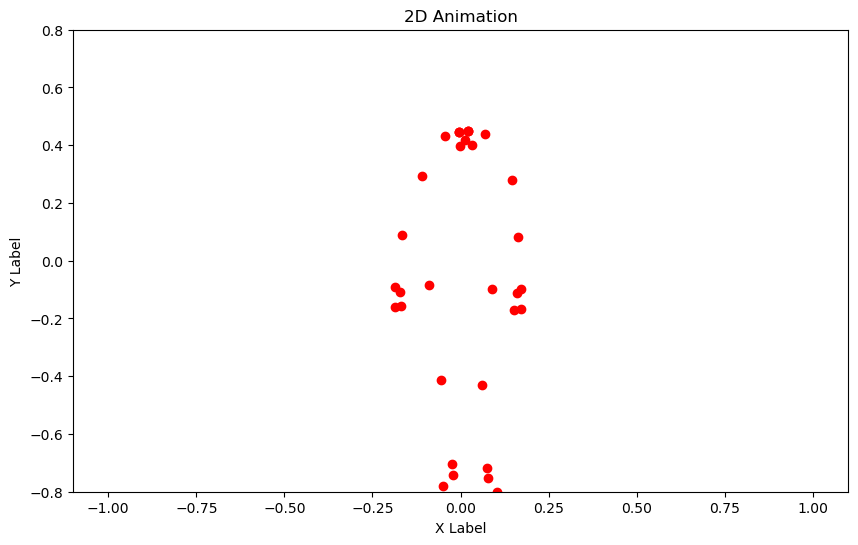

In [21]:
sample2 = '/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/Motion_Processing_Folder/TS_movement/Donner_g_ch2_g1_compr.eaf.csv'
sample2 = pd.read_csv(sample2)
movement_sample2 = sample2[sample2['head_mov'] == 'movement']
#cols = ['X_NOSE', 'Y_NOSE', 'Z_NOSE']
cols = movement_sample2.columns
cols = cols.drop(['time', 'fileID', 'participantID'])
cols = [col for col in cols if '_velocity' not in col]
cols = [col for col in cols if '_speed2D' not in col]
cols = [col for col in cols if '_speed' not in col]
cols = [col for col in cols if '_acceleration2D' not in col]
cols = [col for col in cols if '_acceleration' not in col]
cols = [col for col in cols if '_jerk2D' not in col]
cols = [col for col in cols if '_jerk' not in col]

animation2D(sample2[cols])
